In [41]:
'''
Finger flexion prediction using transformer encoder
@author: Deng Chijun
@date: 2024.11.24

'''
import logging
import os

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, r2_score

from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import seaborn as sns


torch.manual_seed(0) 

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [42]:
'''
load data
'''
root_dir = '/Users/miaolab/Desktop/dengchijun/coursework/bci'
os.chdir(root_dir)

# fingers
fingers = ['thumb', 'index', 'middle', 'ring', 'little']

## subid and finger
subid = 3
finger_id = 0
finger_name = fingers[finger_id]
sigma=6

### load data
data_process_dir = f'{root_dir}/BCI_Competion4_dataset4_data_fingerflexions/preprocessing/sub{subid}'

# train
X_train = np.load(f'{data_process_dir}/train/ecog_data.npy')
y_train_all = np.load(f'{data_process_dir}/train/fingerflex_data.npy')

# test
X_test = np.load(f'{data_process_dir}/val/ecog_data.npy')
y_test_all = np.load(f'{data_process_dir}/val/fingerflex_data.npy')

# Transpose to (times, channels, wavelets)
X_train = X_train.transpose(2, 0, 1)
X_test = X_test.transpose(2, 0, 1)
y_train_all = y_train_all.transpose(1, 0)
y_test_all = y_test_all.transpose(1, 0)

# feature dim
num_wave = X_train.shape[2]
num_node = X_train.shape[1]


In [43]:
'''
torch dataloader
'''

y_train = y_train_all[:, finger_id].reshape([-1, 1])
y_test = y_test_all[:, finger_id].reshape([-1, 1])
y_test_raw = y_test

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [44]:
'''
Transformer Encoder
'''
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers, output_dim, pos_dim, dropout=0.1):
        super(TransformerRegressor, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, pos_dim, embed_dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, 
                                                   dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.fc = nn.Linear(embed_dim, output_dim)
    
    def forward(self, x):
        # Reshape input for embedding (batch_size, sequence_length, input_dim)
        x = x.permute(0, 2, 1)  # (batch_size, freq, channels)
        x = self.embedding(x) + self.positional_encoding  # Add positional encoding
        
        # Transformer expects shape (sequence_length, batch_size, embed_dim)
        x = x.permute(1, 0, 2)  # (freq, batch_size, embed_dim)
        x = self.transformer_encoder(x)  # Pass through transformer encoder
        
        x = x.mean(dim=0)  # Aggregate over the frequency dimension
        x = self.fc(x)  # Output layer
        return x

In [45]:
'''
Model Setup
'''
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

model = TransformerRegressor(input_dim=num_node, embed_dim=256, num_heads=8,
                             num_layers=2, output_dim=1,
                             pos_dim=num_wave).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# Initialize a list to store loss values
loss_history = []
# Step 5: Training Loop
# Epoch
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")


Epoch 1/10, Loss: 0.0755
Epoch 2/10, Loss: 0.0266
Epoch 3/10, Loss: 0.0203
Epoch 4/10, Loss: 0.0172
Epoch 5/10, Loss: 0.0155
Epoch 6/10, Loss: 0.0139
Epoch 7/10, Loss: 0.0122
Epoch 8/10, Loss: 0.0125
Epoch 9/10, Loss: 0.0135
Epoch 10/10, Loss: 0.0137


In [46]:
'''
Evaluation and Inference
'''
y_pred = []
model.eval()
test_loss = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        test_loss += loss.item()
        
        y_pred.append(predictions.cpu().numpy())
        
y_pred = np.concatenate(y_pred, axis=0)  # Combine batch predictions

print(f"Test Loss: {test_loss / len(test_loader):.4f}")

Test Loss: 0.0119


In [47]:
# Calculate Pearson correlation, MSE, and R^2
y_pred_filter = gaussian_filter1d(y_pred.ravel(), sigma=sigma)  # Smooth predictions
rho, _ = pearsonr(y_test_raw.ravel(), y_pred_filter)
mse = mean_squared_error(y_test_raw.ravel(), y_pred_filter)

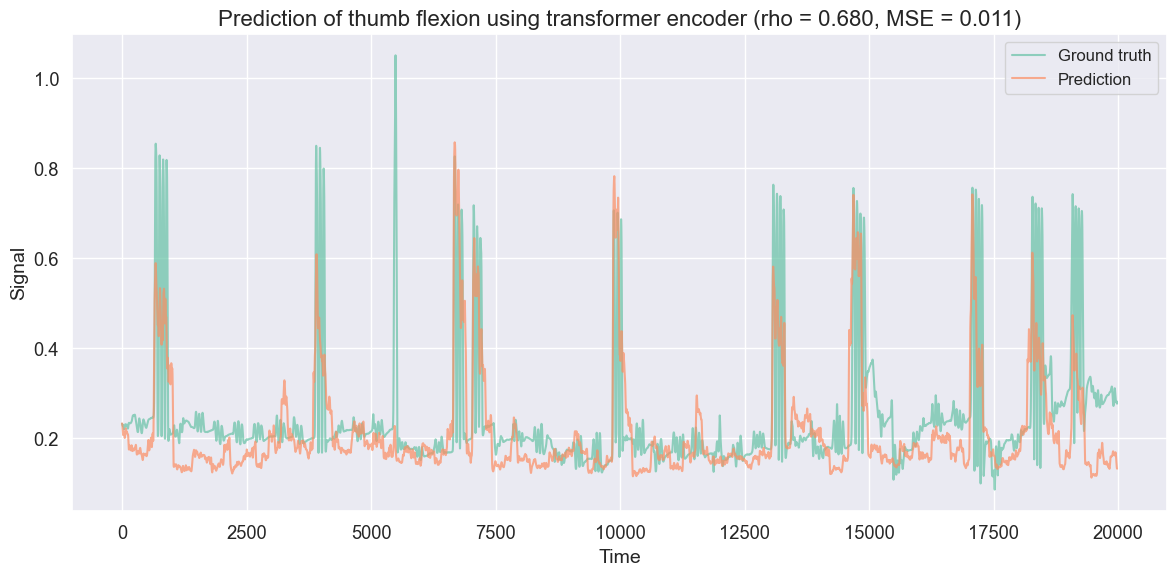

In [51]:
'''
Visualize
'''
sns.set_theme(style='darkgrid', font_scale=1.2)
# Define a color palette
colors = sns.color_palette("Set2", 2) 
# Plot original y vs. predicted y
plt.figure(figsize=(12, 6))

# Plot original y
plt.plot(y_test_raw.ravel(), label="Ground truth", alpha=0.7, color=colors[0])

# Plot predicted y
plt.plot(y_pred_filter.ravel(), label="Prediction", alpha=0.7, color=colors[1])

# Adding labels and legend
plt.title(f"Prediction of {finger_name} flexion using transformer encoder (rho = {rho:.3f}, MSE = {mse:.3f})", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Signal", fontsize=14)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()